In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
#import plotly.graph_objs as go
%matplotlib inline

In [2]:
from pandas_datareader import data as pdr

C:\Users\reejung\anaconda3\envs\tf\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [3]:
date_end = dt.datetime.today()
date_start = date_end - dt.timedelta(30)

## Web scraping S&P100 companies from Wikipedia table

In [4]:
import requests
website_url = requests.get("https://en.wikipedia.org/wiki/S%26P_100").text

from bs4 import BeautifulSoup
soup = BeautifulSoup(website_url,'lxml')
print(soup.prettify())

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   S&amp;P 100 - Wikipedia
  </title>
  <script>
   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"d714ef03-f19d-4244-bb15-a047308f9855","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"S\u0026P_100","wgTitle":"S\u0026P 100","wgCurRevisionId":959665002,"wgRevisionId":959665002,"wgArticleId":2658424,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Articles with short description","American stock market indices","S\u0026P Dow Jones Indices"],"wgPageContentLanguage":"en","wgPageContentModel":"wikitext"

In [5]:
wiki_table = soup.find('table',{'class':'wikitable sortable'})

In [6]:
data = []
tHeader = []
SP100_tickers = pd.DataFrame()

for tr in wiki_table.find_all("tr"):
    for th in tr.find_all("th")[:1]:
        tHeader = th.get_text(strip=True)
        SP100_tickers[tHeader] = []
    for td in tr.find_all("td")[:1]:
        data.append( td.get_text(strip=True))
        
SP100_tickers[tHeader] = data

In [7]:
SP100_tickers

,Symbol
0,AAPL
1,ABBV
2,ABT
3,ACN
4,ADBE
...,...
96,VZ
97,WBA
98,WFC
99,WMT


In [10]:
import timeit
%timeit

df = pd.DataFrame()
for i in data:
    try:
        symbol = SP100_tickers.loc[SP100_tickers['Symbol']==i]
        symbol_data = pdr.DataReader(i, 'yahoo', date_start, date_end).reset_index()
        single_table = pd.concat([symbol, symbol_data], axis=1, ignore_index=False)
        single_table['Symbol'].ffill(inplace=True)
        #display(symbol_data)
        df = df.append(single_table)
    except KeyError: 
        print(symbol + " n/a")
    except (RuntimeError, TypeError, NameError):
        print(symbol + "err")
    except:
        print(symbol, sys.exc_info()[0])
    

       Symbol
18  BRK.B n/a


In [14]:
df

,Symbol,Date,High,Low,Open,Close,Volume,Adj Close
0,AAPL,2020-05-26,324.239990,316.500000,323.500000,316.730011,31380500.0,316.730011
1,AAPL,2020-05-27,318.709991,313.089996,316.140015,318.109985,28236300.0,318.109985
2,AAPL,2020-05-28,323.440002,315.630005,316.769989,318.250000,33390200.0,318.250000
3,AAPL,2020-05-29,321.149994,316.470001,319.250000,317.940002,38399500.0,317.940002
4,AAPL,2020-06-01,322.350006,317.209991,317.750000,321.850006,20197800.0,321.850006
...,...,...,...,...,...,...,...,...
1895,NaN,2020-06-15,47.759998,44.750000,45.349998,47.139999,27929300.0,47.139999
1896,NaN,2020-06-16,49.750000,47.240002,49.570000,48.200001,26203400.0,48.200001
1897,NaN,2020-06-17,48.130001,46.599998,48.000000,46.630001,19251600.0,46.630001
1898,NaN,2020-06-18,47.330002,45.770000,46.110001,46.919998,21478700.0,46.919998


In [12]:
df = df.loc[df['Date'].notnull()]

In [13]:
df = df.reset_index(drop=True)

df.groupby(['Symbol']).describe().transpose()

In [15]:
df = df.groupby(['Date', 'Symbol']).sum()

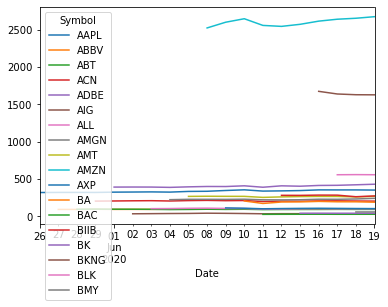

In [16]:
df['Close'].unstack().plot()